#### Dependencies

In [1]:
import numpy as np
import torch as pt 
import ast
import torch.nn as nn
import json
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
import numpy as np
import torch.optim as optim
import random
import copy

In [2]:
#! Check Gpu Availability
if pt.cuda.is_available():
    print("PyTorch is using GPU")
    print(f"GPU device: {pt.cuda.get_device_name(0)}")
else:
    print("PyTorch is not using GPU")


PyTorch is using GPU
GPU device: Tesla P100-PCIE-16GB


In [3]:
def load_data_labels(data_path, labels_path):
    with open(data_path, 'r') as f:
        data = [ast.literal_eval(line.strip()) for line in f]
    with open(labels_path, 'r') as f:
        labels = [ast.literal_eval(line.strip()) for line in f]
    return data, labels


In [4]:
data, labels = load_data_labels('/kaggle/input/orders-dataset/training_data_processedf.txt','/kaggle/input/orders-dataset/train_order_category_labelsf.txt')
print(data[:5])
print(labels[:5])

[['can', 'i', 'have', 'one', 'large', 'bbq', 'pull', 'pork'], ['large', 'pie', 'with', 'green', 'pepper', 'and', 'with', 'extra', 'peperonni'], ['i', 'like', 'one', 'large', 'vegetarian', 'pizza'], ['party', 'size', 'stuff', 'crust', 'pie', 'with', 'american', 'cheese', 'and', 'with', 'mushroom'], ['can', 'i', 'have', 'one', 'personal', 'size', 'artichoke']]
[[2, 2, 2, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 2, 0, 0, 0, 0]]


In [5]:
dev_data, dev_labels = load_data_labels('/kaggle/input/orders-dataset/dev_data_processedf.txt', '/kaggle/input/orders-dataset/dev_order_category_labelsf.txt')
print(dev_data[:5])
print(dev_labels[:5])

[['i', 'want', 'to', 'order', 'two', 'medium', 'pizza', 'with', 'sausage', 'and', 'black', 'olive', 'and', 'two', 'medium', 'pizza', 'with', 'pepperoni', 'and', 'extra', 'cheese', 'and', 'three', 'large', 'pizza', 'with', 'pepperoni', 'and', 'sausage'], ['five', 'medium', 'pizza', 'with', 'tomato', 'and', 'ham'], ['i', 'need', 'to', 'order', 'one', 'large', 'vegetarian', 'pizza', 'with', 'extra', 'banana', 'pepper'], ['i', 'like', 'to', 'order', 'one', 'large', 'onion', 'and', 'pepper', 'pizza'], ['i', 'll', 'have', 'one', 'pie', 'along', 'with', 'pesto', 'and', 'ham', 'but', 'avoid', 'olive']]
[[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 2, 2, 0, 0, 0, 0, 0, 0], [2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


In [6]:
# desired_size=1000000
# while len(data) > desired_size:
#     idx_to_remove = random.randint(0, len(data) - 1)
#     del data[idx_to_remove]
#     del labels[idx_to_remove]

In [7]:
print(len(data))
print(len(labels))

2457303
2457303


In [8]:
def get_vocab_freq(data):
    vocab_freq = {}
    for d in data:
        for w in d:
            if w in vocab_freq:
                vocab_freq[w] += 1
            else:
                vocab_freq[w] = 1
    return vocab_freq
vocab_freq= get_vocab_freq(data)
print(type(vocab_freq))
def replace_with_unk(data, vocab_freq, threshold):
    unk = '<UNK>'
    data_unk = []
    for d in data:
        d_unk = [w if vocab_freq[w] >= threshold else unk for w in d]
        data_unk.append(d_unk)
    return data_unk
data = replace_with_unk(data, vocab_freq, 30)
print(data[:5])

<class 'dict'>
[['can', 'i', 'have', 'one', 'large', 'bbq', 'pull', 'pork'], ['large', 'pie', 'with', 'green', 'pepper', 'and', 'with', 'extra', 'peperonni'], ['i', 'like', 'one', 'large', 'vegetarian', 'pizza'], ['party', 'size', 'stuff', 'crust', 'pie', 'with', 'american', 'cheese', 'and', 'with', 'mushroom'], ['can', 'i', 'have', 'one', 'personal', 'size', 'artichoke']]


In [9]:
vocab= set()
for d in data:
    vocab.update(d)
vocab.add('<PAD>')
print(len(vocab))
word2idx = {w: i for i, w in enumerate(vocab)}

265


In [10]:
embedding_dim=150
input_dim=len(word2idx)
output_dim=3
max_length=100

In [11]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokens = [self.vocab.get(word, self.vocab['<UNK>']) for word in text]
        
        return tokens, label
def collate_fn(batch):
    # batch.sort(key=lambda x: len(x[0]), reverse=True)  # Sort by sequence length
    
    sequences, labels = zip(*batch)  
    max_len = max(len(seq) for seq in sequences)  
    
    padded_sequences = []
    labels_list = []  
    
    for seq, label in zip(sequences, labels):
        padded_seq = list(seq) + [word2idx['<PAD>']] * (max_len - len(seq))  
        padded_labels = list(label) + [-1] * (max_len - len(seq))
        padded_sequences.append(pt.tensor(padded_seq))
        # print(padded_labels)
        labels_list.append(padded_labels)  
        
    
    padded_sequences = pt.stack(padded_sequences)
    labels_tensor = pt.tensor(labels_list, dtype=pt.long)  
    return padded_sequences, labels_tensor
train_dataset = TextDataset(data, labels ,word2idx, max_length)
dev_dataset = TextDataset(dev_data, dev_labels, word2idx, max_length)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)


In [12]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_dim, max_length):
        super(BiLSTMModel, self).__init__()
        
        #! Embedding Layer: learnable word embeddings
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        #! Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            bidirectional=True,  
            batch_first=True      #! Input shape (batch_size, seq_len)
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim*2 , hidden_dim),
            nn.ReLU()
        )
        
        #! Output layer for each time step
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        
        
        packed_out, (hn, cn) = self.lstm(embedded)
        
        intermediate_output = self.fc(packed_out.data)

        output = self.output_layer(intermediate_output)  
        
        
        return output

In [13]:
model = BiLSTMModel(input_dim, embedding_dim, 256,2, output_dim, max_length)
model.to('cuda')


BiLSTMModel(
  (embedding): Embedding(265, 150)
  (lstm): LSTM(150, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (output_layer): Linear(in_features=256, out_features=3, bias=True)
)

In [14]:
loss_function = nn.CrossEntropyLoss(ignore_index=-1)


In [15]:
history = {'train_loss': [], 'train_acc': [], 'dev_loss': [], 'dev_acc': []}

In [16]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [17]:
num_epochs =20


In [18]:
best_model=None
best_acc=0

In [19]:
for epoch in range(num_epochs):
    model.train() 
    running_train_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()  
        
        # Forward pass
        inputs = inputs.to('cuda')
        output = model(inputs)
        output_flat = output.view(-1, output_dim)
        labels_flat = labels.view(-1)
        output_flat = output_flat.to('cuda')
        labels_flat = labels_flat.to('cuda')
        loss = loss_function(output_flat, labels_flat)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()

        _, predicted = pt.max(output_flat, -1)  
        mask = labels_flat != -1
        predicted=predicted[mask]
        labels_flat=labels_flat[mask]
        correct_train_preds += (predicted == labels_flat).sum().item()
        total_train_preds += labels_flat.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train_preds / total_train_preds
    
    model.eval()  
    running_val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0
    
    with pt.no_grad(): 
        for inputs, labels in dev_loader:
            inputs = inputs.to('cuda')
            output = model(inputs)
            output_flat = output.view(-1, output_dim)
            labels_flat = labels.view(-1)
            output_flat = output_flat.to('cuda')
            labels_flat = labels_flat.to('cuda')
            loss = loss_function(output_flat, labels_flat)
            
            running_val_loss += loss.item()
             
    
            _, predicted = pt.max(output_flat, -1) 
            mask = labels_flat != -1
            predicted=predicted[mask]
            labels_flat=labels_flat[mask]
            correct_val_preds += (predicted == labels_flat).sum().item()
            total_val_preds += labels_flat.size(0)

    avg_val_loss = running_val_loss / len(dev_loader)
    val_accuracy = 100 * correct_val_preds / total_val_preds
    if  best_acc < val_accuracy:
        best_acc = val_accuracy
        best_model = copy.deepcopy(model)
    scheduler.step(avg_train_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    print("------------------------------------------------------------------------------------")
    history['train_acc'].append(train_accuracy)   
    history['dev_acc'].append(val_accuracy)
    history['train_loss'].append(avg_train_loss)
    history['dev_loss'].append(avg_val_loss)

Epoch 1/20
Training Loss: 0.0057, Training Accuracy: 99.81%
Validation Loss: 0.1448, Validation Accuracy: 96.30%
------------------------------------------------------------------------------------
Epoch 2/20
Training Loss: 0.0002, Training Accuracy: 100.00%
Validation Loss: 0.0679, Validation Accuracy: 98.14%
------------------------------------------------------------------------------------
Epoch 3/20
Training Loss: 0.0002, Training Accuracy: 100.00%
Validation Loss: 0.0631, Validation Accuracy: 98.20%
------------------------------------------------------------------------------------
Epoch 4/20
Training Loss: 0.0001, Training Accuracy: 100.00%
Validation Loss: 0.0923, Validation Accuracy: 97.38%
------------------------------------------------------------------------------------
Epoch 5/20
Training Loss: 0.0001, Training Accuracy: 100.00%
Validation Loss: 0.0603, Validation Accuracy: 98.54%
------------------------------------------------------------------------------------
Epoch 

Text(0.5, 1.0, 'Training and Validation Accuracy')

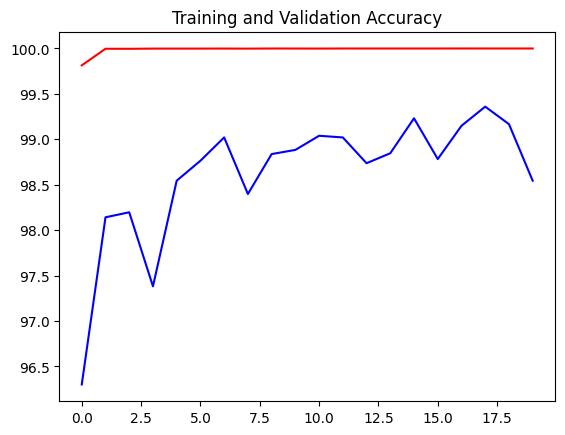

In [20]:
plt.plot(history['train_acc'], label='Training Accuracy', color='red')
plt.plot(history['dev_acc'], label='Validation Accuracy', color='blue')
plt.title('Training and Validation Accuracy')

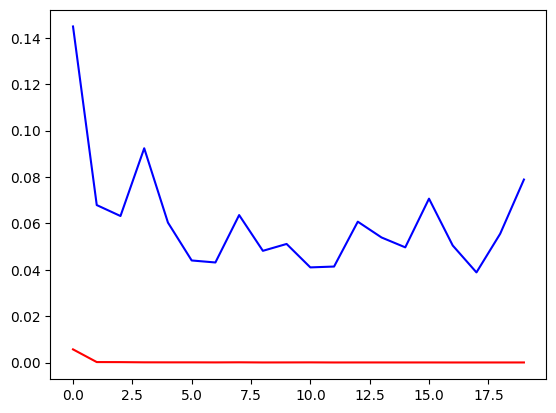

In [21]:
plt.plot(history['train_loss'], label='Training Loss', color='red')
plt.plot(history['dev_loss'], label='Validation Loss', color='blue')

In [22]:
model = best_model
preds_dev=[]
lbls=[]
with pt.no_grad(): 
        for inputs, labels in dev_loader:
            inputs = inputs.to('cuda')
            output = model(inputs)
            _, predicted = pt.max(output, -1) 
            for pred in predicted:
                preds_dev.append(pred)
            for lbl in labels:
                  lbls.append(lbl)
                     
# i = 0
# for pred,lbl in zip(preds_dev,lbls):
#       print(i)
#       pred=pred.tolist()
#       lbl=lbl.tolist()
#       print(pred[:len(dev_data[i])])
#       print(lbl[:len(dev_data[i])])
#       print('-------------------')
#       i+=1

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [23]:
#! calculate exact match between predicted and true labels
correct=0
i=0
for pred,lbl in zip(preds_dev,lbls):
    pred=pred.tolist()
    lbl=lbl.tolist()
    if pred[:len(dev_data[i])]==lbl[:len(dev_data[i])]:
        correct+=1
    else:
        print(i)
        print(pred[:len(dev_data[i])])
        print(lbl[:len(dev_data[i])])
        print('-------------------')
    with open('model_output.txt', 'a') as f: 
        f.write("%s\n" % pred[:len(dev_data[i])])
    i+=1
print(correct/len(preds_dev))

69
[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 1]
[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1]
-------------------
163
[2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 0, 2]
[2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]
-------------------
177
[2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 2, 0]
[2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 2, 2]
-------------------
181
[2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2]
[2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
-------------------
183
[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
-------------------
197
[2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
-------------------
204
[2, 2, 0, 0, 0, 0]
[2, 2, 0, 0, 0, 2]
-------------------
208
[2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
[2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---

In [24]:
input_sentence = [['i', 'want', 'two', 'pizza', 'one','with', 'pepper', 'and', 'one', 'with', 'pepperoni', 'thank']]

# Tokenize and convert to indices
input_indices = [[word2idx[word] if word in vocab else word2idx['<UNK>'] for word in sentence] for sentence in input_sentence]
# Convert to PyTorch tensor
input_tensor = pt.tensor(input_indices, dtype=pt.long)
input_tensor=input_tensor.to('cuda')

# Forward pass through the model
output = model(input_tensor)
_, predicted = pt.max(output, -1) 
print("Output:", predicted)

Output: tensor([[2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2]], device='cuda:0')


In [25]:
#pt.save(model, 'model.pth')
#model = pt.load('/kaggle/input/orders-dataset/model.pth')


In [26]:
preds_dev=[]
lbls=[]
with pt.no_grad(): 
        for inputs, labels in dev_loader:
            inputs = inputs.to('cuda')
            output = model(inputs)
            _, predicted = pt.max(output, -1) 
            for pred in predicted:
                preds_dev.append(pred)
            for lbl in labels:
                  lbls.append(lbl)

In [27]:
#! calculate exact match between predicted and true labels
correct=0
i=0
for pred,lbl in zip(preds_dev,lbls):
    pred=pred.tolist()
    lbl=lbl.tolist()
    if pred[:len(dev_data[i])]==lbl[:len(dev_data[i])]:
        correct+=1
    else:
        print(i)
        print(pred[:len(dev_data[i])])
        print(lbl[:len(dev_data[i])])
        print('-------------------')
        with open('model_output.txt', 'a') as f: 
            f.write("%s\n" % pred[:len(dev_data[i])])
    i+=1
print(correct/len(preds_dev))

69
[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 1, 1]
[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1]
-------------------
163
[2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 0, 2]
[2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]
-------------------
177
[2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 2, 0]
[2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 2, 2]
-------------------
181
[2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2]
[2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
-------------------
183
[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
-------------------
197
[2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
-------------------
204
[2, 2, 0, 0, 0, 0]
[2, 2, 0, 0, 0, 2]
-------------------
208
[2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]
[2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
---

In [28]:
# preds_train=[]
# lbls_train=[]
# with pt.no_grad(): 
#         for inputs, labels in train_loader:
#             inputs = inputs.to('cuda')
#             output = model(inputs)
#             # print(output[0])
#             _, predicted = pt.max(output, -1) 
#             for pred in predicted:
#                 preds_train.append(pred)
#             for lbl in labels:
#                 lbls_train.append(lbl)
# i = 0
# for pred,lbl in zip(preds_train,lbls_train):
#       pred=pred.tolist()
#       lbl=lbl.tolist()
  

In [29]:
# #! calculate exact match between predicted and true labels
# correct=0
# i=0
# for pred,lbl in zip(preds_train,lbls_train):
#     pred=pred.tolist()
#     lbl=lbl.tolist()
#     if preds_train[:len(data[i])]==lbls_train[:len(data[i])]:
#         correct+=1
#     i+=1
# print(correct/len(preds_dev))

In [79]:
with open('/kaggle/input/orders-dataset/test_tokens.txt', 'r') as f:
    tdata = [ast.literal_eval(line.strip()) for line in f]
print(tdata[:5])
with open('/kaggle/input/orders-dataset/test_tokens_vocab_fixed.txt', 'r') as f:
    tdatav = [ast.literal_eval(line.strip()) for line in f]
print(tdatav[:5])

[['let', 'me', 'prefer', 'one', 'extra', 'large', 'saute', 'spinach', 'and', 'tomato', 'pizza', 'without', 'any', 'sausage'], ['could', 'you', 'give', 'me', 'one', 'exta', 'large', 'pizza', 'with', 'roast', 'red', 'pepper', 'and', 'more', 'cheese', 'but', 'no', 'sausage'], ['can', 'you', 'handle', 'this', 'order', 'one', 'pizza', 'make', 'it', 'etra', 'large', 'please', 'i', 'want', 'new', 'york', 'style', 'tomato', 'sauce', 'but', 'absolutely', 'no', 'onion', 'that', 's', 'important', 'that', 's', 'all'], ['let', 'me', 'try', 'five', 'lnch', 'pizza', 'with', 'garlic', 'onion', 'and', 'pesto'], ['i', 'need', 'you', 'to', 'order', 'me', 'one', 'pie', 'in', 'med', 'size', 'along', 'with', 'pesto', 'pan', 'and', 'ham']]
[['let', 'me', 'prefer', 'one', 'extra', 'large', 'sauce', 'spinach', 'and', 'tomato', 'pizza', 'without', 'any', 'sausage'], ['could', 'you', 'give', 'me', 'one', 'extra', 'large', 'pizza', 'with', 'roast', 'red', 'pepper', 'and', 'more', 'cheese', 'but', 'no', 'sausage']

In [80]:
labels=[]
for row in tdatav:
    labels.append([0] * len(row))

In [81]:
test_dataset1 = TextDataset(tdata, labels, word2idx, max_length)
test_dataset2 = TextDataset(tdatav, labels, word2idx, max_length)


In [82]:
test_loader1 = DataLoader(test_dataset1, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader2 = DataLoader(test_dataset2, batch_size=64, shuffle=False, collate_fn=collate_fn)


In [83]:
preds_test=[]
lbls=[]
with pt.no_grad(): 
        for inputs, labels in test_loader1:
            inputs = inputs.to('cuda')
            output = model(inputs)
            _, predicted = pt.max(output, -1) 
            for pred in predicted:
                preds_test.append(pred)
            for lbl in labels:
                  lbls.append(lbl)

In [84]:
correct=0
i=0
for pred,lbl in zip(preds_test,lbls):
    pred=pred.tolist()
    lbl=lbl.tolist()
    with open('test_out_vocab.txt', 'a') as f: 
        f.write("%s\n" % pred[:len(tdata[i])])
    i+=1


In [85]:
preds_test=[]
lbls=[]
with pt.no_grad(): 
        for inputs, labels in test_loader2:
            inputs = inputs.to('cuda')
            output = model(inputs)
            _, predicted = pt.max(output, -1) 
            for pred in predicted:
                preds_test.append(pred)
            for lbl in labels:
                  lbls.append(lbl)

In [86]:
correct=0
i=0
for pred,lbl in zip(preds_test,lbls):
    pred=pred.tolist()
    lbl=lbl.tolist()
    with open('test_out_vocab_fixed.txt', 'a') as f: 
        f.write("%s\n" % pred[:len(tdata[i])])
    i+=1
